In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import matplotlib
from tqdm.notebook import tqdm

In [2]:
ls

DATA.zip  ImageNet.zip  S1_Binary.ipynb  S1_data/


In [3]:
data ='./S1_data'
os.listdir(data)
len(os.listdir(data))

2

In [4]:
unique_plants = []
cl = os.listdir('./S1_data')
for i in cl:
    x = i.split('__')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  2
Unique Plants:  ['nonplant', 'plant']


In [5]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])

In [6]:
dataset = ImageFolder(data,transform=transform)
test_ds = ImageFolder(data,transform=transform)

In [7]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  7394
Number of testing images:  7394


In [8]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  2
['nonplant', 'plant']


In [9]:
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [11]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

In [12]:

class ImageClassificationBase(nn.Module):
    def accuracy(self, outputs, labels):
      _, preds = torch.max(outputs, dim=1)
      return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = self.accuracy(out,labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_loss = [out['val_loss'] for out in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [out['val_acc'] for out in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class Plant_Disease_Model(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16
        
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8
        
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),
        
        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,2)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

In [14]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [15]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [19]:
model = to_device(Plant_Disease_Model(), device)

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader

def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

def fit_with_early_stopping(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.Adam, patience=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    optimizer = opt_func(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    counter = 0  # 개선이 없는 에포크 수를 세는 변수
    
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        # 학습 단계
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            total_train += targets.size(0)
            correct_train += (outputs.argmax(dim=1) == targets).sum().item()
        
        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        
        # 검증 단계
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                total_val += targets.size(0)
                correct_val += (outputs.argmax(dim=1) == targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

        # Early stopping 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break
    
    print('Training complete.')
    return history


In [21]:
history = fit_with_early_stopping(epochs=100, learning_rate=0.001, model=model, train_loader=train_loader, val_loader=val_loader, opt_func=torch.optim.Adam, patience=5)


Epoch 1/100, Training Loss: 0.6911682236341783, Training Accuracy: 0.5255023183925811, Validation Loss: 0.6802944285529, Validation Accuracy: 0.6880072137060415
Epoch 2/100, Training Loss: 0.42817006821249737, Training Accuracy: 0.8261205564142194, Validation Loss: 0.40589279362133573, Validation Accuracy: 0.8570784490532011
Epoch 3/100, Training Loss: 0.3321313695223243, Training Accuracy: 0.8939335394126738, Validation Loss: 0.24141145880733217, Validation Accuracy: 0.9066726780883679
Epoch 4/100, Training Loss: 0.2407084980312689, Training Accuracy: 0.9136398763523956, Validation Loss: 0.2370237248284476, Validation Accuracy: 0.9107303877366997
Epoch 5/100, Training Loss: 0.24199575259361739, Training Accuracy: 0.9167310664605873, Validation Loss: 0.20298159761088236, Validation Accuracy: 0.9192966636609559
Epoch 6/100, Training Loss: 0.1990577296158414, Training Accuracy: 0.9292890262751159, Validation Loss: 0.22022624569279806, Validation Accuracy: 0.9206492335437331
Epoch 7/100, 

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
history

{'train_loss': [0.6911682236341783,
  0.42817006821249737,
  0.3321313695223243,
  0.2407084980312689,
  0.24199575259361739,
  0.1990577296158414,
  0.18988909940292806,
  0.18437618753056467,
  0.21152190772103674,
  0.17848806064805867,
  0.1733185426780471,
  0.16174768366747433,
  0.20156662350083576,
  0.17585480295949513,
  0.15107815765580276,
  0.1405776505484993],
 'train_accuracy': [0.5255023183925811,
  0.8261205564142194,
  0.8939335394126738,
  0.9136398763523956,
  0.9167310664605873,
  0.9292890262751159,
  0.9314142194744977,
  0.9300618238021638,
  0.92870942812983,
  0.9364374034003091,
  0.9379829984544049,
  0.9412673879443586,
  0.9258114374034003,
  0.9374034003091191,
  0.9459041731066461,
  0.9486089644513137],
 'val_loss': [0.6802944285529,
  0.40589279362133573,
  0.24141145880733217,
  0.2370237248284476,
  0.20298159761088236,
  0.22022624569279806,
  0.20559627562761307,
  0.20737826111061233,
  0.19430346616676875,
  0.18522571484957423,
  0.1740597731300

In [25]:
evaluate(model,val_loader)

{'val_loss': 0.17730942368507385, 'val_acc': 0.941241443157196}

In [26]:
torch.save(model.state_dict(), 's1_binary_class.pth')

In [27]:
scripted_model = torch.jit.script(model)
scripted_model.save("model_v1_scripted.pth")

In [28]:
import pandas as pd

def save_history_to_csv(history, csv_file):
    df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train Loss': history['train_loss'],
        'Train Accuracy': history['train_accuracy'],
        'Val Loss': history['val_loss'],
        'Val Accuracy': history['val_accuracy']
    })
    df.to_csv(csv_file, sep='\t', index=False)

# Usage

In [29]:
save_history_to_csv(history, 'training_history.csv')


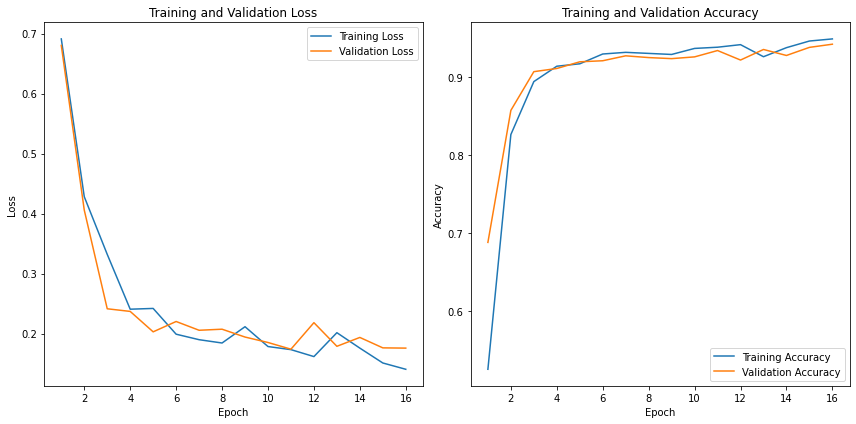

In [31]:
import matplotlib.pyplot as plt

def plot_training_history(history, save_plot_path=None):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plotting Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save or Show Plot
    if save_plot_path:
        plt.savefig(save_plot_path)
    else:
        plt.show()

# Usage
plot_training_history(history, save_plot_path='training_history_plot.png')
